In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score,confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier
   

import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')

/Users/natalie/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
test = pd.read_parquet('/Users/natalie/Desktop/DS Thesis/Code/data/test.parquet')
train = pd.read_parquet('/Users/natalie/Desktop/DS Thesis/Code/data/train.parquet')

In [3]:
TARGET ='churn_user'
CATEGORICAL_FEATURES  = ['os_name', 'age_group','gender', 'country', 'region', 'province_type',
                         'province']
DATETIME_FEATURES  = ['first_date', 'lastest_active_day']
SEARCH_CC_FEATURES = [ 'clicks', 'search_volume', 'dating_search', 'videoclip_search', 'technical_search', 'housekeeping_family_search', 'marketing_search', 'other_search']
SEARCH_GG_FEATURES = [ 'serp_click', 'search_volume_gg', 'search_clicks_gg', 'other_search_gg','housekeeping_family_search_gg','videoclip_search_gg', 'dating_search_gg', 'marketing_search_gg', 'technical_search_gg']
ACTIVE_FEATURES = ['active_day', 'life_time',  'not_active_day', 'total_active_time']
ADS_FEATURES =  ['ads_impression', 'ads_click', 'ads_revenue']
OTHERS_FEATURES =['newtab_count', 'download_count', 'pip_count', 'sidebar_count', 'incognito_count', 'signin_count', 'youtube_count',
                    'work_count', 'social_count', 'news_count', 'entertainment_count', 'ecommerce_count']
NUMERICAL_FEATURES = SEARCH_CC_FEATURES + SEARCH_GG_FEATURES + ACTIVE_FEATURES + ADS_FEATURES + OTHERS_FEATURES

MODEL_NAMES = ['log_reg', 'randomforest','lightgbm', 'xgboost', 'mlp']


In [4]:
def find_best_threshold_f1_score(train_labels, oofs, average='macro'):
    scores = []
    thresholds = []
    best_score = 0
    best_threshold = 0
    for threshold in np.arange(0.1, 0.9, 0.01):
        print(f'{threshold:.02f}, ', end='')
        preds = (oofs > threshold).astype('int')
        m = f1_score(train_labels, preds, average=average)
        scores.append(m)
        thresholds.append(threshold)
        if m > best_score:
            best_score = m
            best_threshold = threshold
    return best_threshold, best_score

In [5]:
def fillna(df):
    df['total_active_time'] = df['total_active_time'].fillna(0)
    df['ads_impression'] = df['ads_impression'].fillna(0)
    df['ads_click'] = df['ads_click'].fillna(0)
    df['ads_revenue'] = df['ads_revenue'].fillna(0)
    df['clicks'] = df['clicks'].fillna(0)
    for c in OTHERS_FEATURES:
        df[c] = df[c].fillna(0)
    return df

def process_data(df,oh_encoder=None, robust_scaler=None,agg_features=None):
    if not oh_encoder:
        print("fit train OneHotEncoder")
        oh_encoder = OneHotEncoder()
        oh_encoder.fit(df[CATEGORICAL_FEATURES])
    else:
        print("loadd onehot encoder")
    if not robust_scaler:
        print("fit train RobustScaler")
        robust_scaler = RobustScaler()
        robust_scaler.fit(df[NUMERICAL_FEATURES])
    else:
        print("loadd robust scaler")
    df_cat = pd.DataFrame(oh_encoder.transform(df[CATEGORICAL_FEATURES]).toarray())
    new_cat_cols = oh_encoder.get_feature_names_out(CATEGORICAL_FEATURES)
    df_cat.columns = new_cat_cols
    df_num = pd.DataFrame(robust_scaler.transform(df[NUMERICAL_FEATURES]))
    df_num.columns = NUMERICAL_FEATURES
    new_df = pd.concat([df_cat.reset_index(drop=True), df_num.reset_index(drop=True)], axis=1)
    new_df = fillna(new_df)
    return new_df, oh_encoder, robust_scaler

In [6]:
N_ESTIMATORS = 200
SEED=42

RF_Hyperparameters = {
    'n_estimators': N_ESTIMATORS,
    'max_depth':8,
    'random_state':SEED,
    'max_features': 'sqrt', 
    'n_jobs': -1
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
models = []
def cross_validate_get_feature_importance(train,FEATURES=None,USE_SMOTE=False, USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    oofs = np.zeros((train.shape[0], len(MODEL_NAMES)))
    for i, (train_index, valid_index) in enumerate(kfold.split(train, train[TARGET])):
        print(f"===========fold {i}================")
        X_train, oh_encoder, robust_scaler = process_data(train.iloc[train_index])
        X_valid, _, _  = process_data(train.iloc[valid_index], oh_encoder,robust_scaler)
        if FEATURES is not None:
            X_train = X_train[FEATURES]
            X_valid = X_valid[FEATURES]
        print(X_train.isnull().sum())
        y_train = train.iloc[train_index][TARGET].values
        y_valid = train.iloc[valid_index][TARGET].values
        rf_hyperparameters = RF_Hyperparameters.copy()
        if USE_SMOTE:
            print("SMOTEEEE")
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
        elif USE_CLASS_WEIGHT:
            print("CLASS_WEIGHTTTT")
           
            class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
            class_weights =  {0: class_weights[0], 1: class_weights[1]}
            rf_hyperparameters['class_weight'] = class_weights
        elif USE_UNDER_SAMPLING:
            print("UNDER SAMPLING")
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
        print("Random Forest--------------")
        rf_model = RandomForestClassifier(**rf_hyperparameters)
        rf_model.fit(X_train, y_train)
        rf_y_pred_proba = rf_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, rf_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in rf_y_pred_proba]

        print(roc_auc_score(y_valid, rf_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,1] = rf_y_pred_proba
        models.append(rf_model)
        
    return oofs, models

In [7]:
X_train,oh_encoder,robust_scaler = process_data(train)
X_test, _,_ = process_data(test,oh_encoder,robust_scaler)
y_train = train[TARGET].values
y_test = test[TARGET].values

fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler


In [8]:
nothing_oofs, rf_models = cross_validate_get_feature_importance(train)

===========fold 0================
fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler
os_name_macos          0
os_name_windows        0
age_group_15-17        0
age_group_18-24        0
age_group_25-34        0
                      ..
work_count             0
social_count           0
news_count             0
entertainment_count    0
ecommerce_count        0
Length: 123, dtype: int64
Random Forest--------------
0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
 best_threshold 0.3599999999999999 best_score 0.7659885653034679
0.8

In [9]:
feats = []
for i, model in enumerate(rf_models):
    feat = pd.DataFrame({ 'features': model.feature_names_in_,f'score_{i}': rf_models[0].feature_importances_})
    feats.append(feat)
f = feats[0].merge(feats[1], on='features').merge(feats[2], on='features')
f['score'] = (f['score_0'] + f['score_1'] + f['score_2'])/3
f.sort_values('score',ascending=False, inplace=True)

In [10]:
feats = []
for i, model in enumerate(rf_models):
    feat = pd.DataFrame({ 'features': model.feature_names_in_, f'score_{i}': model.feature_importances_})
    feats.append(feat)

# Assuming you want to merge all features, not just the first three
f = feats[0]
for i in range(1, len(feats)):
    f = f.merge(feats[i], on='features')

# Calculate the average feature importance
score_columns = [f'score_{i}' for i in range(len(feats))]
f['score'] = f[score_columns].mean(axis=1)

# Sort by the average score
f.sort_values('score', ascending=False, inplace=True)

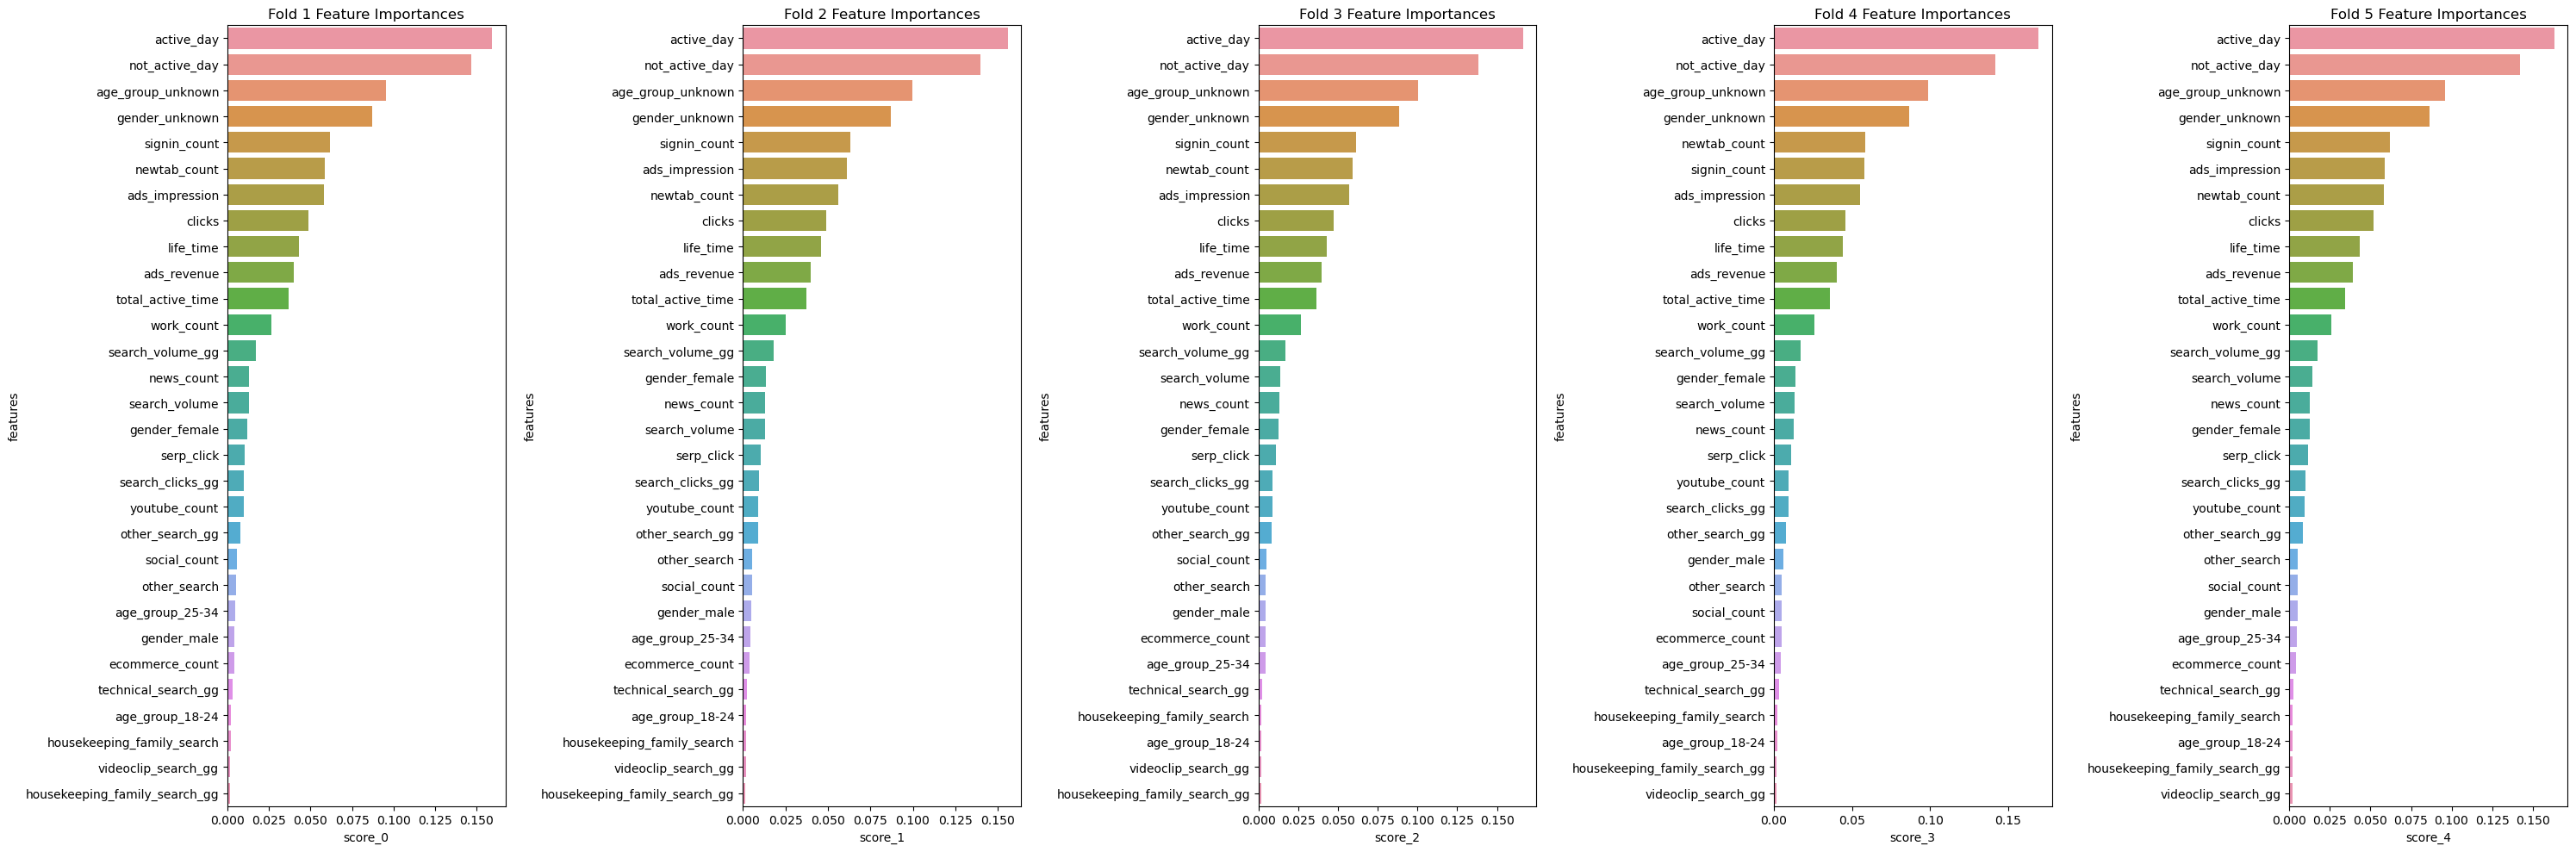

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(30, 10))

# Plotting the feature importances for each fold
for i in range(5):
    sns.barplot(y='features', x=f'score_{i}', data=f.sort_values(f'score_{i}', ascending=False).head(30), ax=axes[i])
    axes[i].set_title(f'Fold {i+1} Feature Importances')

plt.tight_layout()
plt.show()

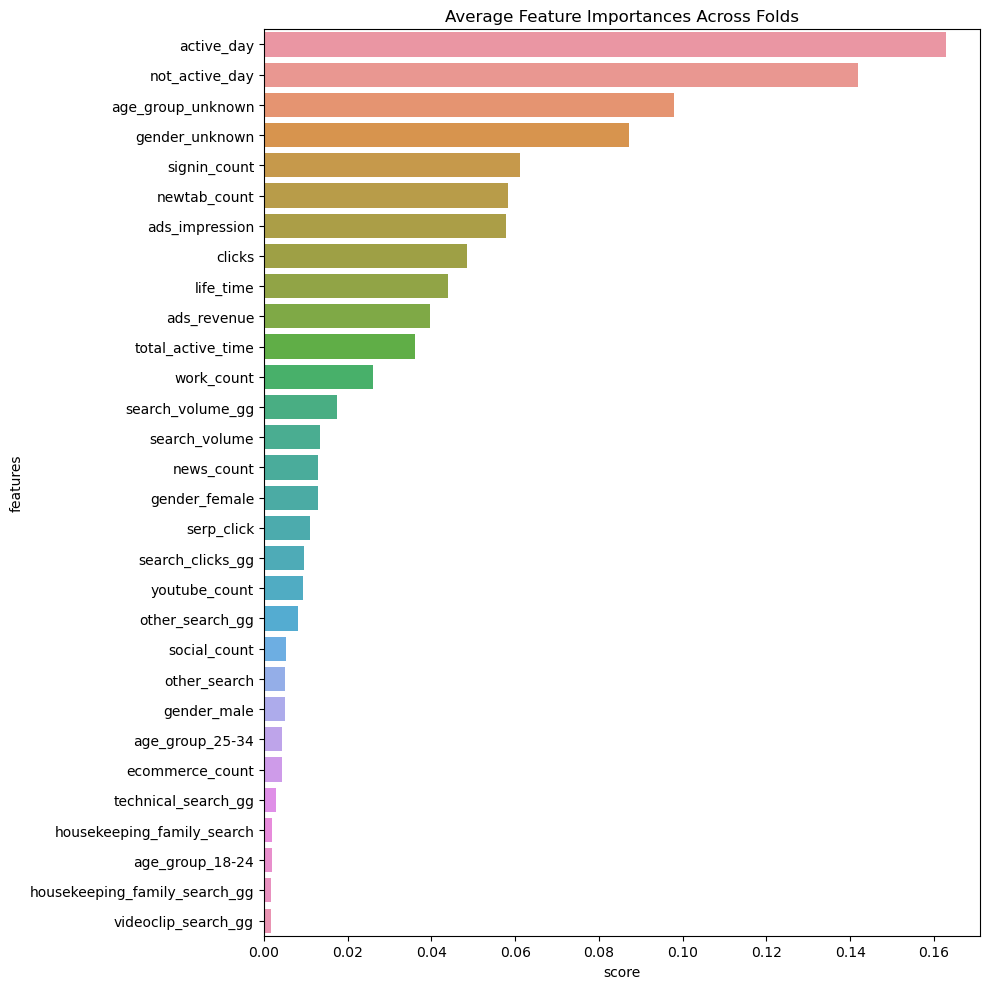

In [12]:
# the average feature importance across all folds
plt.figure(figsize=(10, 10))
sns.barplot(y='features', x='score', data=f.sort_values('score', ascending=False).head(30))
plt.title('Average Feature Importances Across Folds')
plt.tight_layout()
plt.show()

In [13]:
f

,features,score_0,score_1,score_2,score_3,score_4,score
104,active_day,0.159296,0.155740,0.166424,0.169607,0.163285,0.162870
106,not_active_day,0.146794,0.139832,0.138555,0.141981,0.142118,0.141856
9,age_group_unknown,0.095493,0.099811,0.100184,0.098792,0.095811,0.098018
12,gender_unknown,0.087071,0.087044,0.088489,0.086558,0.086667,0.087166
116,signin_count,0.061569,0.063233,0.061272,0.057957,0.062069,0.061220
...,...,...,...,...,...,...,...
50,province_Kon Tum,0.000006,0.000004,0.000005,0.000004,0.000005,0.000005
68,province_Sơn La,0.000003,0.000005,0.000004,0.000004,0.000005,0.000004
34,province_Cao Bằng,0.000004,0.000004,0.000005,0.000006,0.000003,0.000004
39,province_Hà Giang,0.000005,0.000004,0.000005,0.000004,0.000003,0.000004


In [45]:
f.to_csv('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/random_forest_top_features.csv', index=False)

In [8]:
#f = pd.read_csv('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/random_forest_top_features.csv')

In [15]:
top_features = f.features.values

In [10]:
N_ESTIMATORS = 200
SEED=42
LGBM_Hyperparameters =  {
    "n_estimators": N_ESTIMATORS,
    'learning_rate':0.03,
     'max_depth':8,
     #'num_leaves': 2**8,
     'colsample_bytree':0.8,
     'subsample':0.8,
     # 'reg_alpha':8,
     # 'reg_lambda':32,

    "random_state":SEED #,
    #'device':'gpu',
#     "class_weight": "balanced"
}

XGBoost_Hyperparameters = {
    'objective' : 'binary:logistic',
     'eval_metric':['logloss', 'auc'],
     'n_estimators':N_ESTIMATORS,
     'learning_rate':0.03,
     'max_depth':8,
     'colsample_bytree':0.5,
     'subsample':0.8,
     'reg_alpha':8,
     'reg_lambda':32,
     'seed':SEED,
     # 'scale_pos_weight':3,
     'enable_categorical':True,
     'early_stopping_rounds': 50 #,
     #'tree_method':'gpu_hist'
     }
RF_Hyperparameters = {
    'n_estimators': N_ESTIMATORS,
    'max_depth':8,
    'random_state':SEED,
    'max_features': 'sqrt', 
    'n_jobs': -1
}
Logreg_Hyperparameters = {'max_iter':N_ESTIMATORS,'random_state':SEED} 
MLP_Hyperparametesr = {'hidden_layer_sizes':(3,125), 'random_state':SEED, 'max_iter':min(N_ESTIMATORS,100)}
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

def cross_validate(train, FEATURES=None, USE_SMOTE=False, USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    oofs = np.zeros((train.shape[0], len(MODEL_NAMES)))
    for i, (train_index, valid_index) in enumerate(kfold.split(train, train[TARGET])):
        print(f"===========fold {i}================")
        X_train, oh_encoder, robust_scaler = process_data(train.iloc[train_index])
        X_valid, _, _  = process_data(train.iloc[valid_index], oh_encoder,robust_scaler)
        if FEATURES is not None:
            print("Number of features", len(FEATURES))
            X_train = X_train[FEATURES]
            X_valid = X_valid[FEATURES]
        print(X_train.isnull().sum())
        y_train = train.iloc[train_index][TARGET].values
        y_valid = train.iloc[valid_index][TARGET].values
        logreg_hyperparameters = Logreg_Hyperparameters.copy()
        lgb_hyperparameters = LGBM_Hyperparameters.copy()
        xgboost_hyperparameters = XGBoost_Hyperparameters.copy()
        rf_hyperparameters = RF_Hyperparameters.copy()
        mlp_hyperparameters = MLP_Hyperparametesr.copy()
        if USE_SMOTE:
            print("SMOTEEEE")
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
        elif USE_CLASS_WEIGHT:
            print("CLASS_WEIGHTTTT")
           
            class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
            class_weights =  {0: class_weights[0], 1: class_weights[1]}
            lgb_hyperparameters['class_weight'] = class_weights
            logreg_hyperparameters['class_weight'] = class_weights
            xgboost_hyperparameters['scale_pos_weight'] = class_weights[1] /  class_weights[0]
            rf_hyperparameters['class_weight'] = class_weights
        elif USE_UNDER_SAMPLING:
            print("UNDER SAMPLING")
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
        print("LOGREG--------------")
        logreg_model = LogisticRegression(**logreg_hyperparameters)
        logreg_model.fit(X_train, y_train)
        logreg_y_pred_proba = logreg_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, logreg_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in logreg_y_pred_proba]

        print(roc_auc_score(y_valid, logreg_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,0] = logreg_y_pred_proba

        print("Random Forest--------------")
        rf_model = RandomForestClassifier(**rf_hyperparameters)
        rf_model.fit(X_train, y_train)
        rf_y_pred_proba = rf_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, rf_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in rf_y_pred_proba]

        print(roc_auc_score(y_valid, rf_y_pred_proba))

        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,1] = rf_y_pred_proba
    #     models.append(model)
        print("LGBModel--------------")
        lgb_model = LGBMClassifier(**lgb_hyperparameters)
        callbacks = [lgb.early_stopping(200, verbose=50), lgb.log_evaluation(period=50)]
        lgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric=["logloss", "auc"],
                  callbacks=callbacks)

        lgb_y_pred_proba = lgb_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, lgb_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in lgb_y_pred_proba]
        print(roc_auc_score(y_valid, lgb_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index,2] = lgb_y_pred_proba
    #     models.append(model)
        # display(pd.DataFrame({'score': lgb_model.feature_importances_, 'feature': lgb_model.feature_name_}).sort_values('score',ascending=False))

        print("XGBoost--------------")
        xgb_model = XGBClassifier(**xgboost_hyperparameters)
        xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=50)
        xgb_y_pred_proba = xgb_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, xgb_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in xgb_y_pred_proba]
        print(roc_auc_score(y_valid, xgb_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index, 3] = xgb_y_pred_proba
        
        print("MLP------------------")
        mlp_model = MLPClassifier(**mlp_hyperparameters)
        mlp_model.fit(X_train, y_train)
        mlp_y_pred_proba = mlp_model.predict_proba(X_valid)[:,1]
        best_threshold, best_score = find_best_threshold_f1_score(y_valid, mlp_y_pred_proba)
        print(f"\n best_threshold {best_threshold} best_score {best_score}")
        y_pred = [1 if y_hat >=best_threshold else 0 for y_hat in mlp_y_pred_proba]
        print(roc_auc_score(y_valid, mlp_y_pred_proba))
        print(classification_report(y_valid, y_pred, digits=4))
        oofs[valid_index, 4] = mlp_y_pred_proba
    return oofs

In [11]:
accuracy_scores = []
f1_scores = []
auc_scores = []
specificity_scores = []
sensitivity_scores = []
def scoring(y_test,y_pred_proba, best_threshold):
    y_pred = [1 if y_hat >= best_threshold else 0 for y_hat in y_pred_proba]
    acc = accuracy_score(y_test, y_pred)
    _f1_score = f1_score(y_test, y_pred, average='macro')
    auc_score = roc_auc_score(y_test, y_pred_proba)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    print("accuracy", acc)
    print("f1_score", _f1_score)
    print("auc", auc_score)
    print("sensitivity", sensitivity, "specificity", specificity)
    print(classification_report(y_test, y_pred, digits=4))
    return acc, _f1_score, auc_score, specificity, sensitivity

In [12]:
def train_model(oofs,X_train, y_train, X_test, y_test, USE_SMOTE=False,USE_CLASS_WEIGHT=False, USE_UNDER_SAMPLING=False):
    models = []
    predictions = []
    accuracy_scores = []
    f1_scores = []
    auc_scores = []
    specificity_scores = []
    sensitivity_scores = []
    best_thresholds = []
    for i in range(len(MODEL_NAMES)):
        best_threshold, best_score = find_best_threshold_f1_score(train[TARGET].values, oofs[:,i])
        best_thresholds.append(best_threshold)
        print('\n',best_threshold, best_score)
    logreg_hyperparameters = Logreg_Hyperparameters.copy()
    lgb_hyperparameters = LGBM_Hyperparameters.copy()
    xgboost_hyperparameters = XGBoost_Hyperparameters.copy()
    del xgboost_hyperparameters['early_stopping_rounds']
    rf_hyperparameters = RF_Hyperparameters.copy()
    mlp_hyperparameters = MLP_Hyperparametesr.copy()
    if USE_SMOTE:
        print("SMOTEEEE")
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)
    elif USE_CLASS_WEIGHT:
        print("CLASS_WEIGHTTTT")
        class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
        class_weights =  {0: class_weights[0], 1: class_weights[1]}
        lgb_hyperparameters['class_weight'] = class_weights
        logreg_hyperparameters['class_weight'] = class_weights
        xgboost_hyperparameters['scale_pos_weight'] = class_weights[1]/ class_weights[0]
        rf_hyperparameters['class_weight'] = class_weights
    elif USE_UNDER_SAMPLING:
        print("UNDER SAMPLING")
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)

    print("LOGREG--------------")
    logreg_model = LogisticRegression(**logreg_hyperparameters)
    logreg_model.fit(X_train, y_train)
    logreg_y_pred_proba = logreg_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,logreg_y_pred_proba,best_thresholds[0])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(logreg_y_pred_proba)
    models.append(logreg_model)

    print("Random Forest--------------")
    rf_model = RandomForestClassifier(**rf_hyperparameters)
    rf_model.fit(X_train, y_train)
    rf_y_pred_proba = rf_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,rf_y_pred_proba,best_thresholds[1])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(rf_y_pred_proba)
    models.append(rf_model)

    print("LGBModel--------------")
    lgb_model = LGBMClassifier(**lgb_hyperparameters)
    lgb_model.fit(X_train, y_train)
    lgb_y_pred_proba = lgb_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,lgb_y_pred_proba,best_thresholds[2])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(lgb_y_pred_proba)
    models.append(lgb_model)

    print("XGBoost--------------")
    print(xgboost_hyperparameters)
    xgb_model = XGBClassifier(**xgboost_hyperparameters)
    xgb_model.fit(X_train, y_train)
    xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,xgb_y_pred_proba,best_thresholds[3])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(xgb_y_pred_proba)
    models.append(xgb_model)
    
    print("MLP--------------")
    mlp_model = MLPClassifier(**mlp_hyperparameters)
    mlp_model.fit(X_train, y_train)
    mlp_y_pred_proba = mlp_model.predict_proba(X_test)[:,1]
    acc, _f1_score, auc_score, specificity, sensitivity = scoring(y_test,mlp_y_pred_proba,best_thresholds[4])
    accuracy_scores.append(acc)
    f1_scores.append(_f1_score)
    auc_scores.append(auc_score)
    specificity_scores.append(specificity)
    sensitivity_scores.append(sensitivity)
    predictions.append(mlp_y_pred_proba)
    models.append(mlp_model)

    print(MODEL_NAMES)
    print(accuracy_scores)
    print(f1_scores)
    print(auc_scores)
    print(specificity_scores)
    print(sensitivity_scores)
    score_df = pd.DataFrame({'model_name': MODEL_NAMES,
                         'accuracy_score':accuracy_scores, 
                         'f1_score': f1_scores, 
                         'auc_score': auc_scores, 
                         'specificity_score': specificity_scores, 
                         'sensitivity_score': sensitivity_scores})
    return score_df,models, predictions

In [13]:
X_train,oh_encoder,robust_scaler = process_data(train)
X_test, _,_ = process_data(test,oh_encoder,robust_scaler)
y_train = train[TARGET].values
y_test = test[TARGET].values

fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler


In [19]:
nothing_oofs = cross_validate(train,FEATURES=top_features[:10])
nothing_score_df, nothing_models, nothing_predictions = train_model(nothing_oofs,X_train[top_features[:10]], y_train, X_test[top_features[:10]], y_test)

===========fold 0================
fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler
Number of features 10
active_day           0
not_active_day       0
age_group_unknown    0
gender_unknown       0
signin_count         0
newtab_count         0
ads_impression       0
clicks               0
life_time            0
ads_revenue          0
dtype: int64
LOGREG--------------
0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
 best_threshold 0.4099999999999998 best_score 0.7626944581010868
0.8785232474647239
              precision    

In [22]:
nothing_score_dfs = []
for n_features in [20,30,40,50,60,100]:
    print(n_features)
    nothing_oofs_ = cross_validate(train,FEATURES=top_features[:n_features])
    nothing_score_df_, nothing_models_, nothing_predictions_ = train_model(nothing_oofs_,X_train[top_features[:n_features]], y_train, X_test[top_features[:n_features]], y_test)
    nothing_score_dfs.append(nothing_score_df_)

20
===========fold 0================
fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler
Number of features 20
active_day           0
not_active_day       0
age_group_unknown    0
gender_unknown       0
signin_count         0
newtab_count         0
ads_impression       0
clicks               0
life_time            0
ads_revenue          0
total_active_time    0
work_count           0
search_volume_gg     0
search_volume        0
news_count           0
gender_female        0
serp_click           0
search_clicks_gg     0
youtube_count        0
other_search_gg      0
dtype: int64
LOGREG--------------
0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69,

In [26]:
nothing_score_dfs[0]

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,log_reg,0.824080,0.763896,0.879435,0.879675,0.652414
1,randomforest,0.827780,0.779592,0.896402,0.857434,0.736214
2,lightgbm,0.832790,0.782566,0.900184,0.869375,0.719822
3,xgboost,0.831520,0.782166,0.900118,0.865477,0.726669
4,mlp,0.826385,0.778190,0.896955,0.855554,0.736316


In [27]:
nothing_score_dfs[1]

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,log_reg,0.821125,0.763073,0.879034,0.871176,0.666578
1,randomforest,0.825135,0.777650,0.894999,0.852072,0.741957
2,lightgbm,0.832850,0.782706,0.900272,0.869263,0.720415
3,xgboost,0.830220,0.782616,0.900520,0.859301,0.740424
4,mlp,0.822840,0.776885,0.896754,0.845069,0.754200


In [28]:
nothing_score_dfs[2]

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,log_reg,0.821710,0.763040,0.878179,0.873281,0.662470
1,randomforest,0.822810,0.776609,0.894238,0.845665,0.752238
2,lightgbm,0.830990,0.782136,0.900495,0.863504,0.730593
3,xgboost,0.831610,0.782664,0.900900,0.864590,0.729776
4,mlp,0.825605,0.777771,0.895912,0.853588,0.739198


In [29]:
nothing_score_dfs[3]

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,log_reg,0.825115,0.764974,0.878411,0.881005,0.652536
1,randomforest,0.824105,0.775613,0.893649,0.853211,0.734231
2,lightgbm,0.831355,0.782650,0.900551,0.863636,0.731676
3,xgboost,0.832345,0.783407,0.900940,0.865589,0.729694
4,mlp,0.824540,0.777274,0.896408,0.850716,0.743715


In [30]:
nothing_score_dfs[4]

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,log_reg,0.822205,0.763743,0.878762,0.873512,0.663778
1,randomforest,0.819345,0.769846,0.890187,0.849319,0.726791
2,lightgbm,0.831110,0.782522,0.900589,0.863008,0.732617
3,xgboost,0.832530,0.783839,0.901200,0.865232,0.731554
4,mlp,0.829700,0.778736,0.896811,0.866880,0.714896


In [23]:
final_nothing_oofs_ = cross_validate(train)
final_nothing_score_df_, final_nothing_models_, final_nothing_predictions_ = train_model(final_nothing_oofs_,X_train, y_train, 
                                                                                         X_test, y_test)

===========fold 0================
fit train OneHotEncoder
fit train RobustScaler
loadd onehot encoder
loadd robust scaler
os_name_macos          0
os_name_windows        0
age_group_15-17        0
age_group_18-24        0
age_group_25-34        0
                      ..
work_count             0
social_count           0
news_count             0
entertainment_count    0
ecommerce_count        0
Length: 123, dtype: int64
LOGREG--------------
0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 
 best_threshold 0.4099999999999998 best_score 0.762850413679721
0.878491361

In [24]:
final_nothing_score_df_

,model_name,accuracy_score,f1_score,auc_score,specificity_score,sensitivity_score
0,log_reg,0.822345,0.763644,0.878688,0.874207,0.662204
1,randomforest,0.817675,0.764139,0.887284,0.856600,0.697482
2,lightgbm,0.833010,0.782841,0.900574,0.869547,0.720190
3,xgboost,0.832300,0.783515,0.901103,0.865146,0.730879
4,mlp,0.827505,0.779278,0.897401,0.857156,0.735948


In [31]:
outputs = [nothing_score_df] + nothing_score_dfs + [final_nothing_score_df_]

In [32]:
for i, n_features in enumerate([10,20,30,40,50,60,100, 'all']):
    outputs[i]['n_features'] = str(n_features)

In [ ]:
!pip install openpyxl

In [34]:
t = pd.concat(outputs)

In [38]:
print(t.dtypes)

model_name            object
accuracy_score       float64
f1_score             float64
auc_score            float64
specificity_score    float64
sensitivity_score    float64
n_features            object
dtype: object


In [40]:
t.to_csv('/Users/natalie/Desktop/DS Thesis/user-churn-prediction/outputs/random_forest_feature_selection.csv', index=False)